In [112]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
#import pymc3 as pm
import seaborn as sns
import dateutil.parser
import datetime
from datetime import timedelta
from datetime import date
import calendar

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_rows', 500)

In [2]:
#######################
# standard code block #
#######################

%pylab inline
# see https://ipython.readthedocs.io/en/stable/interactive/magics.html

%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Choose to download(True) or read from file (False)
download = False

if download:
    dates = ['210529','210522','210515','210508']

    M_data = []
    for wk_date in dates:
        MTA_url = f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{wk_date}.txt"
        M_data.append(pd.read_csv(MTA_url))
        
    MTA_data = pd.concat(M_data)
    MTA_data.to_csv('turnstile_backup.csv')
else:
    MTA_data = pd.read_csv("turnstile_backup.csv")

In [4]:
# so it's easier to deal with, rename C/A to CA and drop unused columns
MTA_data.rename(columns={"C/A": "CA"}, inplace=True)
MTA_data.drop(['LINENAME', 'DIVISION','DESC'], axis=1,inplace=True)
MTA_data.head(10)

,Unnamed: 0,CA,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS
0,0,A002,R051,02-00-00,59 ST,05/22/2021,00:00:00,7575503,2588978
1,1,A002,R051,02-00-00,59 ST,05/22/2021,04:00:00,7575515,2588982
2,2,A002,R051,02-00-00,59 ST,05/22/2021,08:00:00,7575523,2588989
3,3,A002,R051,02-00-00,59 ST,05/22/2021,12:00:00,7575557,2588996
4,4,A002,R051,02-00-00,59 ST,05/22/2021,16:00:00,7575630,2589008
5,5,A002,R051,02-00-00,59 ST,05/22/2021,20:00:00,7575643,2589012
6,6,A002,R051,02-00-00,59 ST,05/23/2021,00:00:00,7575643,2589013
7,7,A002,R051,02-00-00,59 ST,05/23/2021,08:00:00,7575644,2589015
8,8,A002,R051,02-00-00,59 ST,05/23/2021,12:00:00,7575645,2589015
9,9,A002,R051,02-00-00,59 ST,05/23/2021,16:00:00,7575645,2589015


In [5]:
#reset the row indices
MTA_data.reset_index(inplace=True, drop=True)

In [6]:
MTA_data.columns

Index(['Unnamed: 0', 'CA', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [7]:
# fix the EXITS column name to remove white space
MTA_data.columns = MTA_data.columns.str.strip()
MTA_data.columns

Index(['Unnamed: 0', 'CA', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'ENTRIES',
       'EXITS'],
      dtype='object')

In [8]:
#combine the DATE and TIME fields and parse the datetime then add this as a column to the dataframe
MTA_data['datetime'] = pd.to_datetime(MTA_data['DATE'] + ' ' + MTA_data['TIME'])

MTA_data.head()

,Unnamed: 0,CA,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,datetime
0,0,A002,R051,02-00-00,59 ST,05/22/2021,00:00:00,7575503,2588978,2021-05-22 00:00:00
1,1,A002,R051,02-00-00,59 ST,05/22/2021,04:00:00,7575515,2588982,2021-05-22 04:00:00
2,2,A002,R051,02-00-00,59 ST,05/22/2021,08:00:00,7575523,2588989,2021-05-22 08:00:00
3,3,A002,R051,02-00-00,59 ST,05/22/2021,12:00:00,7575557,2588996,2021-05-22 12:00:00
4,4,A002,R051,02-00-00,59 ST,05/22/2021,16:00:00,7575630,2589008,2021-05-22 16:00:00


In [9]:
MTA_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836441 entries, 0 to 836440
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Unnamed: 0  836441 non-null  int64         
 1   CA          836441 non-null  object        
 2   UNIT        836441 non-null  object        
 3   SCP         836441 non-null  object        
 4   STATION     836441 non-null  object        
 5   DATE        836441 non-null  object        
 6   TIME        836441 non-null  object        
 7   ENTRIES     836441 non-null  int64         
 8   EXITS       836441 non-null  int64         
 9   datetime    836441 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 63.8+ MB


In [10]:
# sort by STATION, UNIT, CA, SCP, datetime in this order
MTA_data.sort_values(by = ['STATION','UNIT','CA','SCP','datetime'], inplace=True)

In [11]:
#create a new column whith the difference between the previous day's ENTRIES and the current day's ENTRIES                                  .diff(periods=-1) * -1)
MTA_data['entry_diff'] = (MTA_data.groupby(['STATION','UNIT','CA','SCP'])
                                    ['ENTRIES']
                                    .diff(periods=-1)) * -1

In [12]:
MTA_data.columns

Index(['Unnamed: 0', 'CA', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'ENTRIES',
       'EXITS', 'datetime', 'entry_diff'],
      dtype='object')

In [13]:
#create a new column whith the difference between the previous day's EXITS and the current day's EXITS

MTA_data['exit_diff'] = (MTA_data.groupby(['STATION','UNIT','CA','SCP'])
                                    ['EXITS']
                                    .diff(periods=-1)) * -1

In [14]:
MTA_data = MTA_data[(MTA_data['entry_diff'] >= 0)
                    & (MTA_data['entry_diff'] < 30000)
                    & (MTA_data['exit_diff'] >= 0)
                    & (MTA_data['exit_diff'] < 30000)]

In [15]:
# The data currently has the turnstile differences on the 4 hour time ranges.  
# Now combine to come up with a daily count

MTA_data_daysummary = MTA_data.groupby(['CA','SCP','DATE'])['entry_diff'].sum().reset_index()
MTA_data_daysummary.head()

,CA,SCP,DATE,entry_diff
0,A002,02-00-00,05/01/2021,437.0
1,A002,02-00-00,05/02/2021,276.0
2,A002,02-00-00,05/03/2021,537.0
3,A002,02-00-00,05/04/2021,579.0
4,A002,02-00-00,05/05/2021,616.0


In [16]:
MTA_SCP = MTA_data_daysummary[(MTA_data_daysummary['CA'] == 'A002')
                            & (MTA_data_daysummary['SCP'] == '02-00-00')]

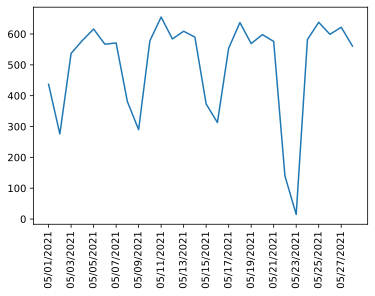

In [17]:
x = MTA_SCP.DATE; y = MTA_SCP.entry_diff
plt.plot(x, y)
plt.xticks(range(0, len(x), 2), MTA_SCP.DATE[::2], rotation=90)
plt.show()

In [18]:
MTA_data_CA_entry = MTA_data.groupby(['CA','UNIT','STATION','DATE'])['entry_diff'].sum().reset_index()
MTA_data_CA_exit  = MTA_data.groupby(['CA','UNIT','STATION','DATE'])['exit_diff'].sum().reset_index()

MTA_data_CA_entry.head()

,CA,UNIT,STATION,DATE,entry_diff
0,A002,R051,59 ST,05/01/2021,3490.0
1,A002,R051,59 ST,05/02/2021,2376.0
2,A002,R051,59 ST,05/03/2021,4559.0
3,A002,R051,59 ST,05/04/2021,4994.0
4,A002,R051,59 ST,05/05/2021,4920.0


In [19]:
MTA_data_Station_entry = MTA_data.groupby(['STATION','DATE'])['entry_diff'].sum().reset_index()
MTA_data_Station_exit  = MTA_data.groupby(['STATION','DATE'])['exit_diff'].sum().reset_index()

MTA_data_Station_entry.head()

,STATION,DATE,entry_diff
0,1 AV,05/01/2021,6115.0
1,1 AV,05/02/2021,4552.0
2,1 AV,05/03/2021,6835.0
3,1 AV,05/04/2021,7240.0
4,1 AV,05/05/2021,7299.0


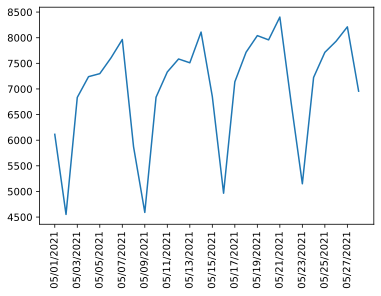

In [20]:
MTA_Station = MTA_data_Station_entry[(MTA_data_Station_entry['STATION'] == '1 AV')]

x = MTA_Station.DATE; y = MTA_Station.entry_diff
plt.plot(x, y)
plt.xticks(range(0, len(x), 2), MTA_Station.DATE[::2], rotation=90)
plt.show()

In [21]:
# for each day and station, find the daily total for entries and exits
MTA_data_Station_entry = MTA_data.groupby(['STATION','DATE','datetime'])['entry_diff'].sum().reset_index()
MTA_data_Station_exit  = MTA_data.groupby(['STATION','DATE','datetime'])['exit_diff'].sum().reset_index()

MTA_data_Station_entry.head(30)

,STATION,DATE,datetime,entry_diff
0,1 AV,05/01/2021,2021-05-01 00:00:00,309.0
1,1 AV,05/01/2021,2021-05-01 04:00:00,175.0
2,1 AV,05/01/2021,2021-05-01 08:00:00,963.0
3,1 AV,05/01/2021,2021-05-01 12:00:00,1690.0
4,1 AV,05/01/2021,2021-05-01 16:00:00,1702.0
5,1 AV,05/01/2021,2021-05-01 20:00:00,1276.0
6,1 AV,05/02/2021,2021-05-02 00:00:00,293.0
7,1 AV,05/02/2021,2021-05-02 04:00:00,114.0
8,1 AV,05/02/2021,2021-05-02 08:00:00,702.0
9,1 AV,05/02/2021,2021-05-02 12:00:00,1299.0


In [22]:
MTA_data_Station_entry = MTA_data.groupby(['STATION'])['entry_diff'].sum().reset_index()
MTA_data_Station_entry.sort_values(by=['entry_diff'], ascending = False, inplace = True)
MTA_data_Station_entry.head(10)

,STATION,entry_diff
61,34 ST-PENN STA,1010682.0
59,34 ST-HERALD SQ,806323.0
110,86 ST,785565.0
233,GRD CNTRL-42 ST,717166.0
9,125 ST,716054.0
14,14 ST-UNION SQ,706756.0
46,23 ST,700606.0
68,42 ST-PORT AUTH,616372.0
217,FLUSHING-MAIN,609374.0
115,96 ST,587004.0


In [23]:
MTA_data_Station_entry = MTA_data.groupby(['STATION', 'TIME'])['entry_diff'].sum().reset_index()
MTA_data_Station_entry.sort_values(by=['entry_diff'], ascending = False, inplace = True)
asd = MTA_data_Station_entry.head(10)

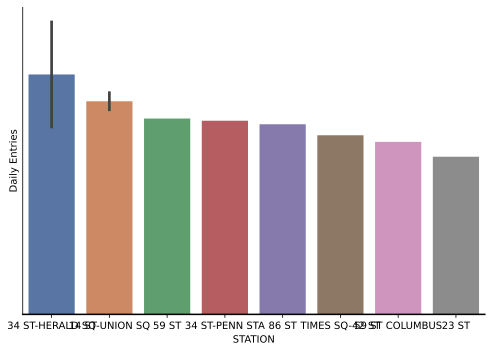

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme(style="white", context="talk")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))


# Generate some sequential data
# x = asd.STATION
# y = asd.entry_diff


# Randomly reorder the data to make it qualitative
sns.barplot(x='STATION', y = 'entry_diff', data = asd, palette="deep", ax=ax)
ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("Daily Entries")

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

In [25]:
def get_day(datetime):
    if (datetime >= '04:00:00') & (datetime < '12:00:00'):
        return 'morning'
    elif (datetime >= '12:00:00') & (datetime < '18:00:00'):
        return 'afternoon'
    elif (datetime >= '18:00:00') & (datetime < '23:00:00'):
        return 'evening'
    else:
        return 'night'

In [26]:
MTA_data['day'] = MTA_data.TIME.apply(get_day)

In [27]:
MTA_data[MTA_data.day == 'morning'].count()

Unnamed: 0    275887
CA            275887
UNIT          275887
SCP           275887
STATION       275887
DATE          275887
TIME          275887
ENTRIES       275887
EXITS         275887
datetime      275887
entry_diff    275887
exit_diff     275887
day           275887
dtype: int64

In [28]:
from pandas.api.types import CategoricalDtype

In [29]:
MTA_data_Station_entry = MTA_data.groupby(['STATION', 'day'])['entry_diff'].sum().reset_index()

cat_size_order = CategoricalDtype(['morning', 'afternoon', 'evening', 'night'], ordered=True)
MTA_data_Station_entry['day'] = MTA_data_Station_entry['day'].astype(cat_size_order)

MTA_data_Station_entry.sort_values('day', inplace = True)

In [30]:
MTA_data_Station_entry

,STATION,day,entry_diff
454,9 AV,morning,38553.0
334,57 ST,morning,15369.0
674,BROOKLYN BRIDGE,morning,21268.0
330,55 ST,morning,8647.0
1294,PROSPECT AV,morning,57662.0
...,...,...,...
1147,MT EDEN AV,night,641.0
551,BAY PKWY,night,1998.0
555,BAY RIDGE AV,night,470.0
1163,NASSAU AV,night,1719.0


In [31]:
MTA_data_Station_entry_top5 = MTA_data_Station_entry[(MTA_data_Station_entry['STATION'] == '34 ST-PENN STA') |
                                                     (MTA_data_Station_entry['STATION'] == '34 ST-HERALD SQ') |
                                                     (MTA_data_Station_entry['STATION'] == '86 ST') |
                                                     (MTA_data_Station_entry['STATION'] == 'GRD CNTRL-42 ST') |
                                                     (MTA_data_Station_entry['STATION'] == '125 ST')]

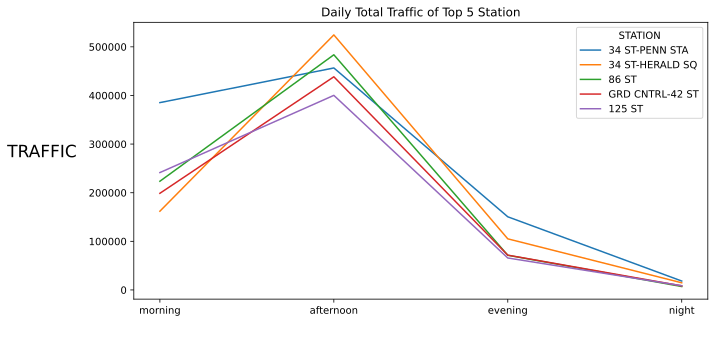

In [164]:
fig, ax = plt.subplots(figsize=(10,5))
day_order = ['morning', 'afternoon', 'evening', 'night']
sns.lineplot(data=MTA_data_Station_entry_top5, x="day", y="entry_diff", hue="STATION")
ax.set_title('Daily Total Traffic of Top 5 Station')
ax.set_ylabel('TRAFFIC', fontsize=17, rotation=0)
ax.set_xlabel(' ')
ax.yaxis.set_label_coords(-0.16, 0.5)
ax.xaxis.set_label_coords(0.5, -0.13)
fig.tight_layout()
plt.savefig('DailyTotalTrafficOfTop5.png', dpi=200, transparent=True)

In [132]:
NYC_data = pd.read_excel("Data2Go.NYC.WorkWealthPov.xlsx", sheet_name= 'Boro')

In [133]:
NYC_median_income = NYC_data.iloc[15:20, [0, 28]]
NYC_median_income.rename(columns={'Unnamed: 0': 'Borough', 'Unnamed: 28': 'median_income'}, inplace=True)
NYC_median_income.sort_values('median_income', ascending=False, inplace = True)

In [134]:
NYC_median_income["Borough"].replace({"Borough of Manhattan": "Manhattan",
                                    "Borough of Staten Island": "Staten Island",
                                    "Borough of Queens": "Queens",
                                    "Borough of Brooklyn": "Brooklyn",
                                    "Borough of the Bronx": "Bronx"}, inplace = True)

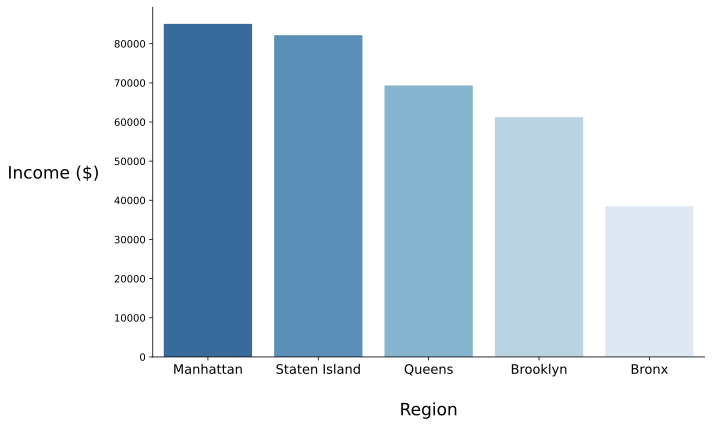

In [135]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Borough', y= 'median_income', data=NYC_median_income, palette="Blues_r", alpha=0.9)
ax.set_ylabel('Income ($)', fontsize=17, rotation=0)
ax.set_xlabel('Region', fontsize=17)
ax.yaxis.set_label_coords(-0.18, 0.5)
ax.xaxis.set_label_coords(0.5, -0.13)
ax.set_xticklabels(labels=NYC_median_income.Borough, fontsize = 13)
fig.tight_layout()
sns.despine(bottom = False, left = False)
plt.savefig('RichesBorough.png', dpi=200, transparent=True)

In [100]:
import geopandas as gpd
import plotly.express as px
import descartes
from shapely.geometry import Point, Polygon
import matplotlib as plt

%matplotlib inline

In [101]:
companies_path = r'~/Documents/codes/istdsa-grup1/comp_locat.csv'
station_path = r'~/Documents/codes/istdsa-grup1/subway_loc.csv'
station_df = pd.read_csv(station_path)

In [102]:
station_df['the_geom'] = station_df['the_geom'].str.lstrip('POINT')
station_df['the_geom'] = station_df['the_geom'].str.strip()
station_df['the_geom'] = station_df['the_geom'].str.lstrip('(')
station_df['the_geom'] = station_df['the_geom'].str.rstrip(')')

new = station_df['the_geom'].str.split(' ', n = 1, expand=True)

station_df['Latitude'] = new[0]
station_df['Longitude'] = new[1]

station_df.drop(columns=['URL', 'OBJECTID', 'LINE', 'NOTES', 'the_geom'], inplace=True)
station_df

,NAME,Latitude,Longitude
0,Astor Pl,-73.99106999861966,40.73005400028978
1,Canal St,-74.00019299927328,40.71880300107709
2,50th St,-73.98384899986625,40.76172799961419
3,Bergen St,-73.97499915116808,40.68086213682956
4,Pennsylvania Ave,-73.89488591154061,40.66471445143568
5,238th St,-73.90087000018522,40.88466700064975
6,Cathedral Pkwy (110th St),-73.95806670661364,40.800581558114956
7,Kingston - Throop Aves,-73.94085899871263,40.67991899941601
8,65th St,-73.8987883783301,40.74971952935675
9,36th St,-73.92901818461539,40.75196004401078


In [103]:
station_df['Latitude'] = station_df['Latitude'].astype(float)
station_df['Longitude'] = station_df['Longitude'].astype(float)

In [104]:
geometry_stations = [Point(xy) for xy in zip(station_df['Latitude'], station_df['Longitude'])]
crs = 'epsg:4326'

In [105]:
station_geo_df = gpd.GeoDataFrame(station_df, crs=crs, geometry=geometry_stations)
station_geo_df

,NAME,Latitude,Longitude,geometry
0,Astor Pl,-73.991070,40.730054,POINT (-73.99107 40.73005)
1,Canal St,-74.000193,40.718803,POINT (-74.00019 40.71880)
2,50th St,-73.983849,40.761728,POINT (-73.98385 40.76173)
3,Bergen St,-73.974999,40.680862,POINT (-73.97500 40.68086)
4,Pennsylvania Ave,-73.894886,40.664714,POINT (-73.89489 40.66471)
5,238th St,-73.900870,40.884667,POINT (-73.90087 40.88467)
6,Cathedral Pkwy (110th St),-73.958067,40.800582,POINT (-73.95807 40.80058)
7,Kingston - Throop Aves,-73.940859,40.679919,POINT (-73.94086 40.67992)
8,65th St,-73.898788,40.749720,POINT (-73.89879 40.74972)
9,36th St,-73.929018,40.751960,POINT (-73.92902 40.75196)


In [106]:
df = pd.read_csv(companies_path).iloc[4:16, :].reset_index()
df.rename(columns={'Unnamed: 0': 'Company', 'Unnamed: 1': 'longitude', 'Unnamed: 2': 'latitude'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      12 non-null     int64  
 1   Company    12 non-null     object 
 2   longitude  12 non-null     object 
 3   latitude   12 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 512.0+ bytes


In [107]:
df_geo = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(
df.latitude, df.longitude))

In [108]:
df['longitude'] = df['longitude'].astype(float)
df['latitude'] = df['latitude'].astype(float)

In [109]:
street_map = gpd.read_file(r'BoroughBoundaries/geo_export_2aa82d34-2650-4796-a429-4001c41ccdda.shp')
street_map

,boro_code,boro_name,shape_area,shape_leng,geometry
0,2.0,Bronx,1.187194e+09,463868.937681,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
1,1.0,Manhattan,6.365759e+08,359804.890798,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
2,5.0,Staten Island,1.623636e+09,325929.794027,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
3,3.0,Brooklyn,1.934174e+09,728195.197649,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4.0,Queens,3.040205e+09,900270.512975,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [150]:
station_top5 = station_geo_df[(station_geo_df.NAME == '34th St - Penn Station')
                             | (station_geo_df.NAME == 'Herald Sq - 34th St')
                             | (station_geo_df.NAME == '86th St')
                             | (station_geo_df.NAME == '125th St')
                             | (station_geo_df.NAME == 'Grand Central - 42nd St')]
station_top5

,NAME,Latitude,Longitude,geometry
30,Grand Central - 42nd St,-73.976713,40.751807,POINT (-73.97671 40.75181)
80,Grand Central - 42nd St,-73.979189,40.752769,POINT (-73.97919 40.75277)
85,86th St,-73.976218,40.788644,POINT (-73.97622 40.78864)
144,Herald Sq - 34th St,-73.987937,40.749645,POINT (-73.98794 40.74964)
164,86th St,-73.968828,40.785823,POINT (-73.96883 40.78582)
167,125th St,-73.945495,40.807754,POINT (-73.94550 40.80775)
203,Grand Central - 42nd St,-73.976041,40.751431,POINT (-73.97604 40.75143)
286,125th St,-73.958372,40.815581,POINT (-73.95837 40.81558)
317,86th St,-74.028398,40.622687,POINT (-74.02840 40.62269)
357,34th St - Penn Station,-73.991057,40.750373,POINT (-73.99106 40.75037)


In [151]:
crs={'init': 'epsg:4326'}

geometry = [Point(xy) for xy in zip(df['latitude'], df['longitude'])]

geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)

/home/monder/.config/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [152]:
# geo_df.head()
# geometry[:3]
# geo_df
# street_map = street_map.to_crs(epsg = 4326)
# geo_df = geo_df.to_crs(epsg = 4326)

In [153]:
fig, ax = plt.subplots(figsize=(10, 19))

ax.set_xlim(-74.06, -73.9)
ax.set_ylim(40.7, 40.83)


street_map.plot(ax = ax, alpha= 0.8, color= '#21201E')
station_top5.plot(ax=ax, markersize=50, marker='^', label='Stations', color='#6495ED')
geo_df.plot(ax = ax, markersize= 50, marker="o", label="Companies", color='#E34602')
plt.legend(prop={'size': 20})
plt.savefig('stations&companies.jpeg', dpi=400)
plt.show()